In [4]:
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [1]:
import time
import os
import numpy as np
from tqdm.notebook import tqdm
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import torch
import torchvision
from torchvision.models import resnet50, ResNet50_Weights, list_models
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.io import read_image, ImageReadMode
from torchvision.transforms import ToTensor

In [3]:
from sklearn.metrics import classification_report

# Create a Dataset instance and Dataloaders

From guide: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files

In [4]:
# borrowing the resize and crop transfrom from resnet40
preprocess = ResNet50_Weights.DEFAULT.transforms()

In [5]:
def load_and_convert_image(file_path):
    # Load the image with transparency using PIL
    img = Image.open(file_path)

    # Check if the image has an alpha channel
    if img.mode == 'RGBA':
        # Create a white background
        new_img = Image.new("RGB", img.size, (255, 255, 255))

        # Paste the image onto the white background, using the alpha channel as a mask
        new_img.paste(img, (0, 0), img)

        # Convert the image to a NumPy array
        rgb_image = np.array(new_img)
    else:
        # If the image doesn't have an alpha channel, just convert it to a NumPy array
        rgb_image = np.array(img)
    
    if rgb_image.shape[2] == 3:
        return  ToTensor()(rgb_image)
    else:
        print('error loading', file_path)
        return None

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, label_transform=None, exclude_labels=[]):
        self.img_dir = img_dir
        self.img_images = []
        self.img_labels = []
        self.transform = transform 
        self.label_transform = label_transform
        
        for label in os.listdir(img_dir):
            if label in exclude_labels:
                continue
            print(f'Loading "{label}" samples:')
            for file in tqdm(os.listdir(os.path.join(img_dir, label))):
                try:
                    image = load_and_convert_image(os.path.join(img_dir, label, file))
                    if image != None:
                        self.img_images.append(image)
                        self.img_labels.append(label)
                except Exception as e:
                    print("Problem opening", file, ':', str(e))

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = self.img_images[idx]
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.label_transform:
            label = self.label_transform(label)
        return image, label

In [7]:
our_dataset = CustomImageDataset(img_dir='pokemon_or_digimon_data/', transform=preprocess, label_transform=lambda l: 1 if l == 'digimon' else 0)

Loading "digimon" samples:


  0%|          | 0/1279 [00:00<?, ?it/s]

Loading "pokemon" samples:


  0%|          | 0/1276 [00:00<?, ?it/s]

Problem opening 800 Necrozma Ultra.png : tuple index out of range
Problem opening 804 Naganadel.png : tuple index out of range


In [8]:
rng = torch.Generator().manual_seed(0)
training_data, valid_data, test_data = random_split(our_dataset, [0.8, 0.1, 0.1], generator=rng)

In [9]:
train_dataloader = DataLoader(training_data, batch_size=8, shuffle=False)
valid_dataloader = DataLoader(valid_data, batch_size=8, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=8, shuffle=False)

In [10]:
train_features, train_labels = next(iter(train_dataloader))
train_features[0], train_labels[0]

C:\Users\harri\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(tensor([[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],
 
         [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          ...,
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],
 
         [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ...,

Feature batch shape: torch.Size([8, 3, 224, 224])
Labels batch shape: tensor([0, 1, 0, 0, 1, 0, 1, 0])


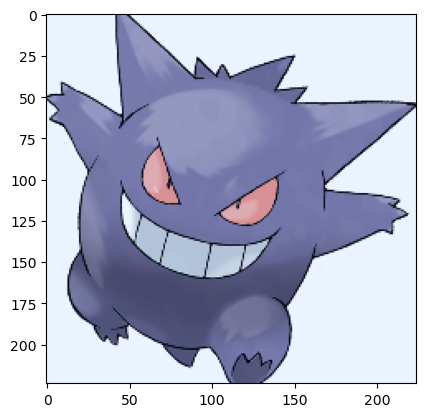

Label: 1


In [11]:
print(f"Feature batch shape: {train_features.shape}")
print(f"Labels batch shape: {train_labels}")
img = train_features[3].squeeze()
label = train_labels[1]
rescaled_img = np.einsum('kij->ijk', img)
rescaled_img = (rescaled_img - np.min(rescaled_img))/(np.max(rescaled_img) - np.min(rescaled_img))

plt.imshow(rescaled_img, cmap="gray")
plt.show()
print(f"Label: {label}")

# Training

In [12]:
torch.cuda.is_available()

True

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
learning_rate = 1e-5
weight_decay = 5e-4
epochs = 5

In [14]:
# Standard CrossEntropy Loss for multi-class classification problems
criterion = torch.nn.CrossEntropyLoss()

In [15]:
def train(net, train_dataloader, valid_dataloader, criterion, optimizer, scheduler=None, epochs=10, device='cpu', checkpoint_epochs=10):
    start = time.time()
    print(f'Training for {epochs} epochs on {device}')
    net = net.to(device)
    
    for epoch in range(1,epochs+1):
        print(f"Epoch {epoch}/{epochs}")
        
        net.train()  # put network in train mode for Dropout and Batch Normalization
        train_loss = torch.tensor(0., device=device)  # loss and accuracy tensors are on the GPU to avoid data transfers
        train_accuracy = torch.tensor(0., device=device)
        
        for X, y in train_dataloader:
            X = X.to(device)
            y = y.to(device)
            preds = net(X)
            loss = criterion(preds, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                train_loss += loss * train_dataloader.batch_size
                train_accuracy += (torch.argmax(preds, dim=1) == y).sum()
        
        if valid_dataloader is not None:
            net.eval()  # put network in train mode for Dropout and Batch Normalization
            valid_loss = torch.tensor(0., device=device)
            valid_accuracy = torch.tensor(0., device=device)
            with torch.no_grad():
                for X, y in valid_dataloader:
                    X = X.to(device)
                    y = y.to(device)
                    preds = net(X)
                    loss = criterion(preds, y)

                    valid_loss += loss * valid_dataloader.batch_size
                    valid_accuracy += (torch.argmax(preds, dim=1) == y).sum()
        
        if scheduler is not None: 
            scheduler.step()
            
        print(f'Training loss: {train_loss/len(train_dataloader.dataset):.2f}')
        print(f'Training accuracy: {100*train_accuracy/len(train_dataloader.dataset):.2f}')
        
        if valid_dataloader is not None:
            print(f'Valid loss: {valid_loss/len(valid_dataloader.dataset):.2f}')
            print(f'Valid accuracy: {100*valid_accuracy/len(valid_dataloader.dataset):.2f}')
        
        if epoch%checkpoint_epochs==0:
            torch.save({
                'epoch': epoch,
                'state_dict': net.state_dict(),
                'optimizer': optimizer.state_dict(),
            }, './checkpoint.pth.tar')
        
        print()
    
    end = time.time()
    print(f'Total training time: {end-start:.1f} seconds')
    return net

### Using a model model from scratch

In [16]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net_1 = Net(num_classes=2)

### Using a known architecture

In [17]:
# https://pytorch.org/vision/stable/models.html

In [18]:
model_2 = resnet50(weights=None)

def get_resnet(resnet, number_of_classes):
    resnet.fc = torch.nn.Linear(resnet.fc.in_features, number_of_classes)
    torch.nn.init.xavier_uniform_(resnet.fc.weight)
    return resnet

model_2 = get_resnet(model_2, number_of_classes=2)

### Start training

In [27]:
optimizer = torch.optim.Adam(net_1.parameters(), lr=learning_rate, weight_decay=weight_decay)
# net_1 = train(net_1, train_dataloader, valid_dataloader, criterion, optimizer, None, epochs, device)

# Batch size!

In [28]:
optimizer = torch.optim.Adam(net_2.parameters(), lr=learning_rate, weight_decay=weight_decay)
net_2 = train(net_2, train_dataloader, valid_dataloader, criterion, optimizer, None, epochs, device)

Training for 5 epochs on cuda
Epoch 1/5


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacty of 11.99 GiB of which 8.25 GiB is free. Of the allocated memory 1.37 GiB is allocated by PyTorch, and 33.87 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [31]:
y_pred = []
y_true = []
net.eval()
with torch.no_grad():
    for X, y in test_dataloader:
        X = X.to(device)
        y = y.to(device)
        y_pred.extend(net(X).argmax(dim=1).type(torch.int32).cpu().numpy())
        y_true.extend(y.type(torch.int32).cpu().numpy())

In [34]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       123
           1       1.00      1.00      1.00       132

    accuracy                           1.00       255
   macro avg       1.00      1.00      1.00       255
weighted avg       1.00      1.00      1.00       255



# Save the model

In [36]:
torch.save({
                'state_dict': net.state_dict(),
                'optimizer': optimizer.state_dict(),
            }, './checkpoint.final.tar')